In [79]:
# !pip install pandas_datareader

In [80]:
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [81]:
#Get the stock
ticker = 'BAC'
stock ="Bank OF America"
# Time step n days, here we will use n  days historical data to predict next day closing
ts_points = 120
# train_data[0:60,0]  

today = datetime.today()
# start_date ='2016-01-01'
start_date = (today - timedelta(days=5*365) ).strftime('%Y-%m-%d')

end_date   = today.strftime('%Y-%m-%d')
stock_df = pdr.DataReader(ticker, data_source="yahoo", start=start_date, end=end_date)

In [82]:
stock_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-10-21,16.670000,16.400000,16.459999,16.670000,77954900.0,15.071189
2016-10-24,16.799999,16.610001,16.750000,16.770000,68244800.0,15.161593
2016-10-25,16.820000,16.680000,16.709999,16.719999,49350300.0,15.116392
2016-10-26,16.870001,16.620001,16.639999,16.870001,58730400.0,15.252005
2016-10-27,17.100000,16.860001,16.950001,16.910000,97937300.0,15.288169
...,...,...,...,...,...,...
2021-10-14,45.099998,43.480000,44.369999,45.070000,82201000.0,45.070000
2021-10-15,46.669998,45.360001,45.770000,46.369999,64248200.0,46.369999
2021-10-18,46.889999,46.029999,46.290001,46.279999,49542500.0,46.279999


In [83]:
# Get shape
stock_df.shape

(1258, 6)

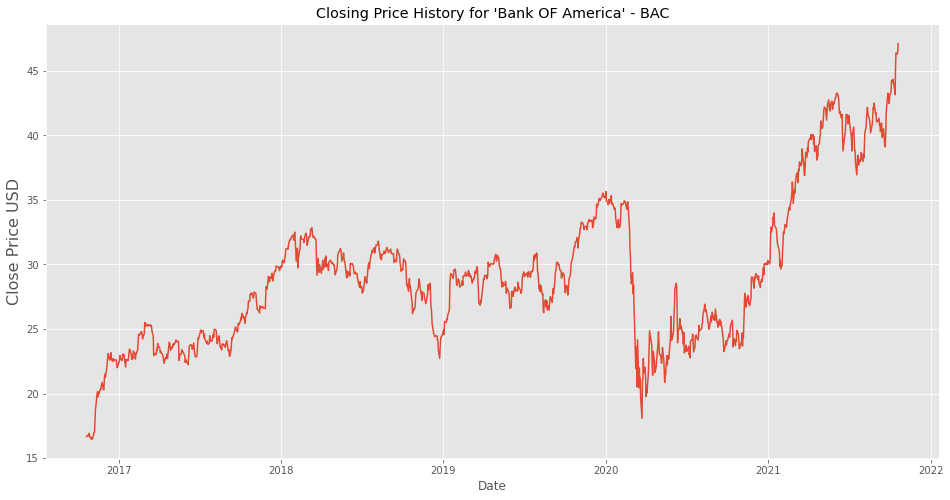

In [84]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(stock_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.show()

In [85]:
# DF with only close
TSdata_df = stock_df.filter(['Close'])
TSdata_arr = TSdata_df.values # this creates an array of Close Price
# TSdata_arr

In [86]:
# Scale the Data
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(TSdata_arr)
# scaled_data

In [87]:
training_data_len = math.ceil(len(TSdata_arr) * 0.75)
training_data_len

944

In [88]:
# Created scaled training dataset
train_data = scaled_data[0:training_data_len]
train_data.shape

(944, 1)

In [89]:
# Split
X_train = []
y_train = []

for i in range(ts_points, len(train_data)):
    X_train.append(train_data[i-ts_points:i,0])
    y_train.append(train_data[i,0])
    # if i <= ts_points+3:
        # print(X_train)
        # print(y_train)
        # print()


In [90]:
# convert X_train and y_train to numpy arrays for LSTM
X_train, y_train = np.array(X_train), np.array(y_train)

In [91]:
print (X_train.shape)
print (y_train.shape)

(824, 120)
(824,)


In [92]:
# LSTM network expects a 3D input (No_of_Samples, number of time steps, and number of features) no_of_features = 1 (Close)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(824, 120, 1)

In [93]:
training_data_len - ts_points

824

In [94]:
# hidden_nodes = int(2/3 * (X_train.shape[1] * 1))
# print(f"The number of hidden nodes is {hidden_nodes}.")

In [95]:
# LSTM MOdel
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.summary()

# model.add(tf.keras.layers.LSTM(hidden_nodes, return_sequences=False, input_shape=(X_train.shape[1],1)))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(1))
# # model.add(tf.keras.layers.Activation('softmax'))

# model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 120, 50)           10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [96]:
model.compile(optimizer='adam', loss='mean_squared_error')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [97]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size=64

os.makedirs("chk_points/", exist_ok=True)
chkpoint_path="chk_points/weights.{epoch}.hdf5"

# Create chk points
chkpt_callback = ModelCheckpoint(filepath=chkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

# chkpoint_path = "chk_points/cp-{epoch:04d}.ckpt"
# chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=chkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*batch_size)                    

# model.save_weights(chkpoint_path.format(epoch=0))    


In [98]:
# training_data_len
# scaled_data

In [99]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=25, validation_split=0.33, callbacks=[chkpt_callback])

Epoch 1/25
9/9 [==============================] - 3s 132ms/step - loss: 0.0636 - val_loss: 0.0279
Epoch 2/25
9/9 [==============================] - 1s 82ms/step - loss: 0.0093 - val_loss: 0.0142
Epoch 3/25
9/9 [==============================] - 1s 87ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 4/25
9/9 [==============================] - 1s 85ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 5/25
9/9 [==============================] - 1s 87ms/step - loss: 0.0035 - val_loss: 0.0073

Epoch 00005: saving model to chk_points\weights.5.hdf5
Epoch 6/25
9/9 [==============================] - 1s 96ms/step - loss: 0.0034 - val_loss: 0.0059
Epoch 7/25
9/9 [==============================] - 1s 133ms/step - loss: 0.0031 - val_loss: 0.0058
Epoch 8/25
9/9 [==============================] - 1s 158ms/step - loss: 0.0028 - val_loss: 0.0053
Epoch 9/25
9/9 [==============================] - 1s 146ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 10/25
9/9 [==============================] - 1s 140ms/step - 

In [100]:
model.save('Model_'+ticker+'.h5')

In [101]:
# test_data = scaled_data[training_data_len:]

# Bring in the last 'ts_points' (60 values) from training set so when X_test is used to predict , predictions have same shape as Y_test
# The for loop starts with 'ts_points' thatbmeans the resultant array will have 60 less rows
test_data = scaled_data[training_data_len-ts_points:]
# test_data[0:60,0]


In [102]:
X_test = []
y_test = TSdata_arr[training_data_len:]
for i in range(ts_points, len(test_data)):
    X_test.append(test_data[i-ts_points:i,0])


In [103]:
# convert the data to a numpy array to use it in LSTM MODEL
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1], 1))

In [104]:
from sklearn.metrics import mean_squared_error

In [105]:
# Models predicted price for X_train
predictions_tr = model.predict(X_train)
predictions_tr = scaler.inverse_transform(predictions_tr)

y_train_tr =  scaler.inverse_transform(y_train.reshape(-1,1))
rmse_tr = math.sqrt(mean_squared_error(y_train_tr, predictions_tr))
rmse_tr

1.2691641898158477

In [106]:
# Models predicted price for X_test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [107]:
y_test.shape, predictions.shape

((314, 1), (314, 1))

In [108]:
# RMSE to check accuracy

rmse = math.sqrt(mean_squared_error(y_test, predictions))
rmse

1.5209760479011347

In [109]:
# Plot
train = TSdata_df[:training_data_len]
actual = TSdata_df[training_data_len:]
actual['Predictions'] = predictions
actual

<ipython-input-109-bb86776ae978>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Predictions'] = predictions


,Close,Predictions
Date,,
2020-07-24,24.350000,24.148489
2020-07-27,24.139999,24.208742
2020-07-28,24.360001,24.259750
2020-07-29,25.270000,24.310349
2020-07-30,24.840000,24.392378
...,...,...
2021-10-14,45.070000,42.833511
2021-10-15,46.369999,42.994995
2021-10-18,46.279999,43.228882


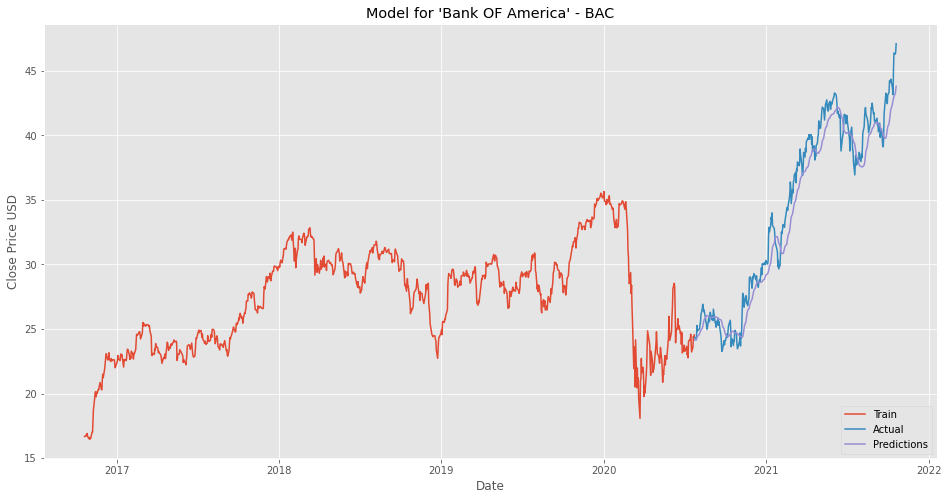

In [110]:
plt.figure(figsize=(16,8))
plt.title(f"Model for '{stock}' - {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price USD")
plt.plot(train['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

# TEST

In [111]:
# for predictions add 100 extra days to make sure it has more than ts_points to make up for missing days (weekends and holidays)

fetch_days = ts_points + 100    

sd =  today - timedelta(days=fetch_days)
sd = sd.strftime('%Y-%m-%d')

ed = today.strftime('%Y-%m-%d')
ed

next_day = (today + timedelta(days=1) ).strftime('%Y-%m-%d')
# next_day

In [112]:
# get the quote
quote = pdr.DataReader(ticker, data_source="yahoo", start=sd, end=ed)
new_df = quote.filter(['Close'])
last_n_days = ts_points
last_n_days_arr = new_df[-last_n_days:].values 

In [113]:
last_n_days_scaled = scaler.transform(last_n_days_arr)
X_test = []
X_test.append(last_n_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))


In [114]:
##########################loading saved model ###############################
new_model = tf.keras.models.load_model('stock_predict_model.h5')

# Check its architecture
new_model.summary()
nmpred_price = new_model.predict(X_test)
nmpred_price = scaler.inverse_transform(nmpred_price)
nmpred_price = nmpred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {nmpred_price:.4f}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Predicted Closing price for 'Bank OF America' on 2021-10-21 is 41.1962


In [115]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = pred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {pred_price:.4f}")

Predicted Closing price for 'Bank OF America' on 2021-10-21 is 44.1179


In [116]:
# verify
d1 = today - timedelta(days=5)
d1 = d1.strftime('%Y-%m-%d')

quote2 = pdr.DataReader(ticker, data_source="yahoo", start=d1)
quote2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-10-15,46.669998,45.360001,45.770000,46.369999,64248200,46.369999
2021-10-18,46.889999,46.029999,46.290001,46.279999,49542500,46.279999
2021-10-19,46.630001,46.200001,46.500000,46.480000,32515500,46.480000
2021-10-20,47.240002,46.049999,46.490002,47.090000,39481326,47.090000
